### Investigation of Top Mass Observables Reweighting

This notebook investigates DCTR reweighting performance on top mass daset

* We use only the hadronic jets as input data 
* We use PFN for DCTR models
* The model is tested on reweighting from observables

### Imports

In [49]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [50]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

### Load the truth data for top mass 172.5 and split 80% for training and 20% for testing

Instead of using hadronic mass we used 3 particle from the hadronic top. 
* Hadronic top: 'hadronicbjet' 'wjet1' 'wjet2'
* Normalization is done as follow
    * eta,phi are centered
    * pT and mW are unit normalized

In [51]:
def normalize(x):
    mask = x[:,0] > 0 # Only process particles with postitive PT
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()
    x[mask,3] /= x[:,3].sum()

In [52]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    return X

In [53]:
data_dir = 'DCTRFitting/'

The indices for the jets are as follow
* 0: part_event['leptonbjet']   + [mtop],
* 1: part_event['hadronicbjet'] + [mtop],
* 2: part_event['lepton']       + [mtop],
* 3: part_event['neutrino']     + [mtop],
* 4 : part_event['wjet1']        + [mtop],
* 5: part_event['wjet2']        + [mtop],

Since we are focusing on hadronic top, we use the indices 1,4,5

In [54]:
default_had_mass_all = preprocess_data(np.load(data_dir + 'part_172_5_6j.npy')[:,[1,4,5],:-1])
default_had_mass = default_had_mass_all[:int(len(default_had_mass_all)*0.8)]
test_had_mass = default_had_mass_all[int(len(default_had_mass_all)*0.8):]

In [56]:
truth_had_mass = preprocess_data(np.load(data_dir + 'part_175_0_6j.npy')[:,[1,4,5],:-1])[:len(default_had_mass)]

### Prepare sample for DCTR reweighting

In [58]:
X0 = default_had_mass
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)

In [59]:
X1 = truth_had_mass
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

In [60]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Define a PFN for reweighting

In [65]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr_model = PFN(input_dim=4, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=False)

In [66]:
from keras.callbacks import LambdaCallback, EarlyStopping

In [67]:
save_label = 'DCTR_pfn_jets'

checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
                                                monitor='val_loss', 
                                                verbose=2, 
                                                save_best_only=True, 
                                                mode='min')

CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [checkpoint, CSVLogger, EarlyStopping]

In [68]:
history = dctr_model.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 10,
                    validation_data = (X_test, Y_test),
                    verbose = 1, 
                    callbacks = callbacks)

Train on 73868 samples, validate on 18468 samples
Epoch 1/100
73868/73868 [==============================] - 54s 736us/step - loss: 0.6971 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.5042

Epoch 00001: val_loss improved from inf to 0.69311, saving model to ./saved_models/DCTR_pfn_jets.h5
Epoch 2/100
73868/73868 [==============================] - 53s 723us/step - loss: 0.6933 - acc: 0.4993 - val_loss: 0.6935 - val_acc: 0.4958

Epoch 00002: val_loss did not improve from 0.69311
Epoch 3/100
73868/73868 [==============================] - 54s 725us/step - loss: 0.6932 - acc: 0.5001 - val_loss: 0.6933 - val_acc: 0.4958

Epoch 00003: val_loss did not improve from 0.69311
Epoch 4/100
73868/73868 [==============================] - 54s 726us/step - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6934 - val_acc: 0.4958

Epoch 00004: val_loss did not improve from 0.69311
Epoch 5/100
73868/73868 [==============================] - 53s 721us/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 

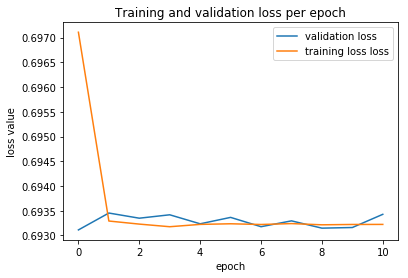

In [69]:
plt.title("Training and validation loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.plot(dctr_model.history.history['val_loss'], label = "validation loss")
plt.plot(dctr_model.history.history['loss'], label = "training loss loss")
plt.legend()
plt.show()

## Reweighting from data of mass 172.5 to 175

### Calculate the weight from DCTR model

In [116]:
X0_test = preprocess_data(test_had_mass)

In [117]:
preds = dctr_model.predict(X0_test)
weights = preds[:,1]/preds[:,0]

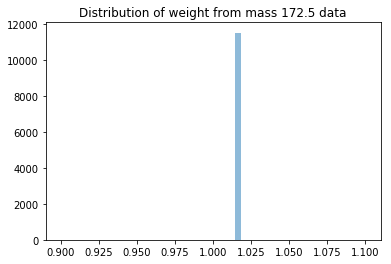

In [118]:
bins = np.linspace(0.9,1.1,50)
plt.hist(weights, bins = bins, alpha = 0.5)[0]
plt.title("Distribution of weight from mass 172.5 data")
plt.show()

### Load jets observables to perform reweighting

In [110]:
X0_test_obs = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1][int(len(default_had_mass_all)*0.8):]
X1_test_obs = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1][:len(X0_test_obs)]

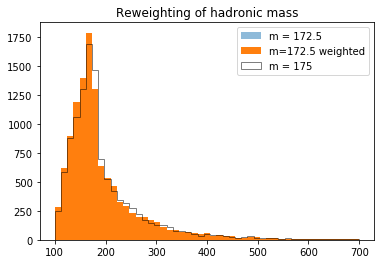

In [114]:
bins = np.linspace(100,700,50)
plt.title("Reweighting of hadronic mass")

target_data_hist = plt.hist(X0_test_obs, bins = bins, alpha = 0.5, label = 'm = 172.5')[0]
reweight_data_hist = plt.hist(X0_test_obs, bins = bins, label = 'm=172.5 weighted', weights=weights)[0]
default_data_hist = plt.hist(X1_test_obs, bins = bins, alpha = 0.5, label = 'm = 175',histtype='step', color='k')[0]
plt.legend()
plt.show()